<a href="https://colab.research.google.com/github/mahdaalma/ALMA-/blob/main/ARIMA_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA

In [1]:
!pip install PythonTsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from scipy.stats import boxcox,  boxcox_llf
from statsmodels.stats.diagnostic import het_arch

import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 5.1 MB/s eta 0:00:00


In [5]:
#Data IHSG dan Variabel Makroekonomi
IHSG=pd.read_csv('https://raw.githubusercontent.com/mahdaalma/ALMA-/refs/heads/main/data_ihsg_2007_2022%20NEW.csv', sep=',')
IHSG.head(10)

,Date,Open,High,Low,Close,AdjClose,Volume,Inflasi,Kurs Jual,Kurs Beli,Kurs Tengah
0,1/31/2007,1813.45,1843.35,1627.76,1757.26,1757.19,501642800,6.26%,9111.818182,9021.181818,9066.500000
1,2/28/2007,1765.87,1824.99,1664.20,1740.97,1740.90,482985200,6.30%,9112.850000,9022.750000,9067.800000
2,3/31/2007,1752.11,1833.42,1692.22,1830.92,1830.85,445107500,6.52%,9209.952381,9117.952381,9163.952381
3,4/30/2007,1837.18,2021.01,1837.18,1999.17,1999.09,486833700,6.29%,9142.900000,9052.200000,9097.550000
4,5/31/2007,1995.17,2111.83,1987.89,2084.32,2084.24,550720100,6.01%,8888.476190,8800.190476,8844.333333
5,6/30/2007,2100.68,2167.45,2045.58,2139.28,2139.19,517207000,5.77%,9028.550000,8938.750000,8983.650000
6,7/31/2007,2140.62,2405.96,2140.62,2348.67,2348.58,376941900,6.06%,9112.363636,9021.909091,9067.136364
7,8/31/2007,2318.70,2322.80,1863.36,2194.34,2194.25,550133600,6.51%,9413.545455,9319.818182,9366.681818
8,9/30/2007,2194.43,2385.24,2192.79,2359.21,2359.11,891354100,6.95%,9356.500000,9263.300000,9309.900000
9,10/31/2007,2366.61,2689.92,2366.61,2643.49,2643.38,876734500,6.88%,9152.705882,9061.411765,9107.058824


In [6]:
#memeriksa tipe data
IHSG.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
AdjClose,float64
Volume,int64
Inflasi,object
Kurs Jual,float64
Kurs Beli,float64


In [7]:
#mengubah type data menjadi datetime
IHSG['Date'] = pd.to_datetime(IHSG['Date'], format='%m/%d/%Y') # Changed the format string to '%m/%d/%Y'

In [8]:
#memeriksa tipe data
IHSG.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
AdjClose,float64
Volume,int64
Inflasi,object
Kurs Jual,float64
Kurs Beli,float64


In [9]:
#Hapus baris yang mengandung NaN
IHSG = IHSG.dropna()


# PREPROCESSING

In [10]:
# Sortir berdasarkan tanggal dan jadikan index
IHSG = IHSG.sort_values('Date')
IHSG.set_index('Date', inplace=True)

# Pilih kolom yang dibutuhkan
data = IHSG[['Close', 'Open']].dropna()

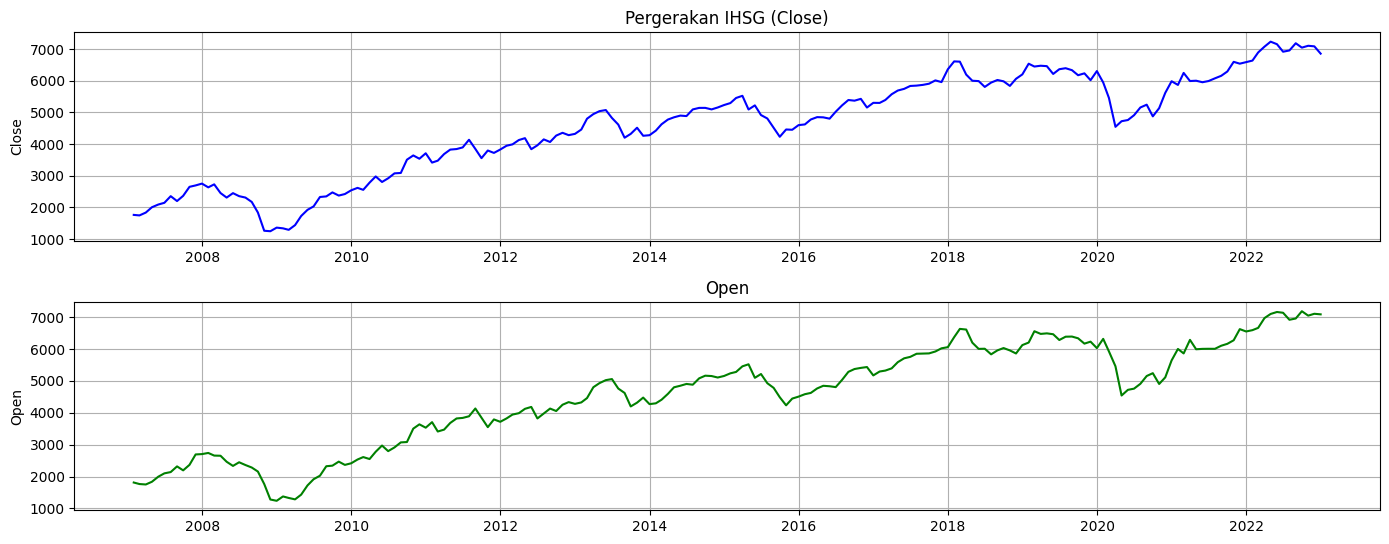

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot Close
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], color='blue')
plt.title('Pergerakan IHSG (Close)')
plt.ylabel('Close')
plt.grid(True)

# Plot Open
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Open'], color='green')
plt.title('Open')
plt.ylabel('Open')
plt.grid(True)


plt.tight_layout()
plt.show()

# SPLITING DATA TRAINING DAN TESTING

In [12]:
# Split di akhir 2022
train = data[:'2020']
test = data['2021':]

y_train = train['Close']
y_test = test['Close']
y_train_open = train['Open']
y_test_open= test['Open']

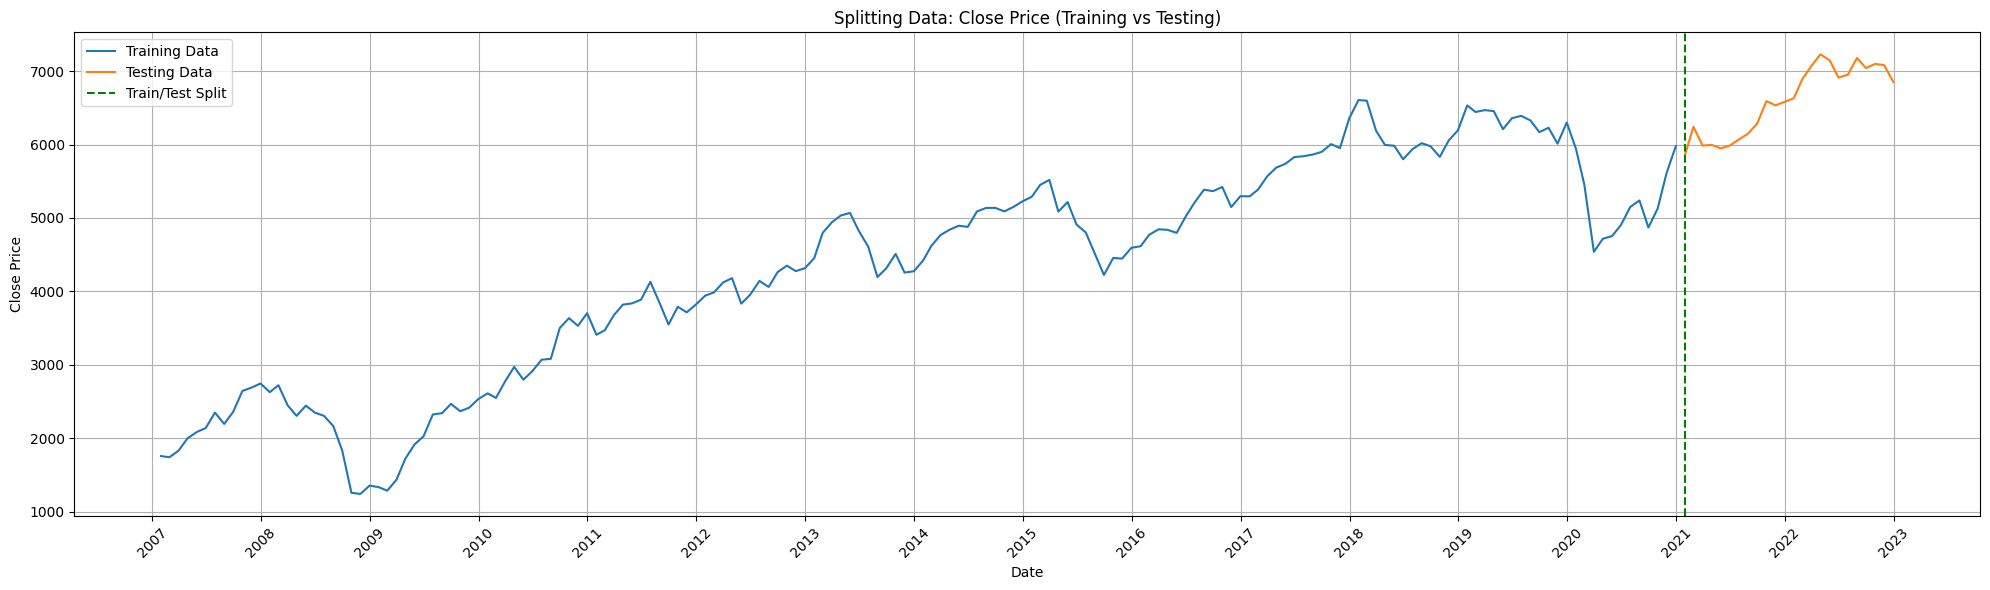

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Testing Data')
plt.axvline(x=y_test.index[0], color='green', linestyle='--', label='Train/Test Split')

# Format sumbu x agar menampilkan semua tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())     # Lokator tahunan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format jadi tahun saja
plt.xticks(rotation=45)  # Rotasi label agar tidak saling tumpang tindih

plt.title('Splitting Data: Close Price (Training vs Testing)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Supaya label tidak terpotong
plt.show()

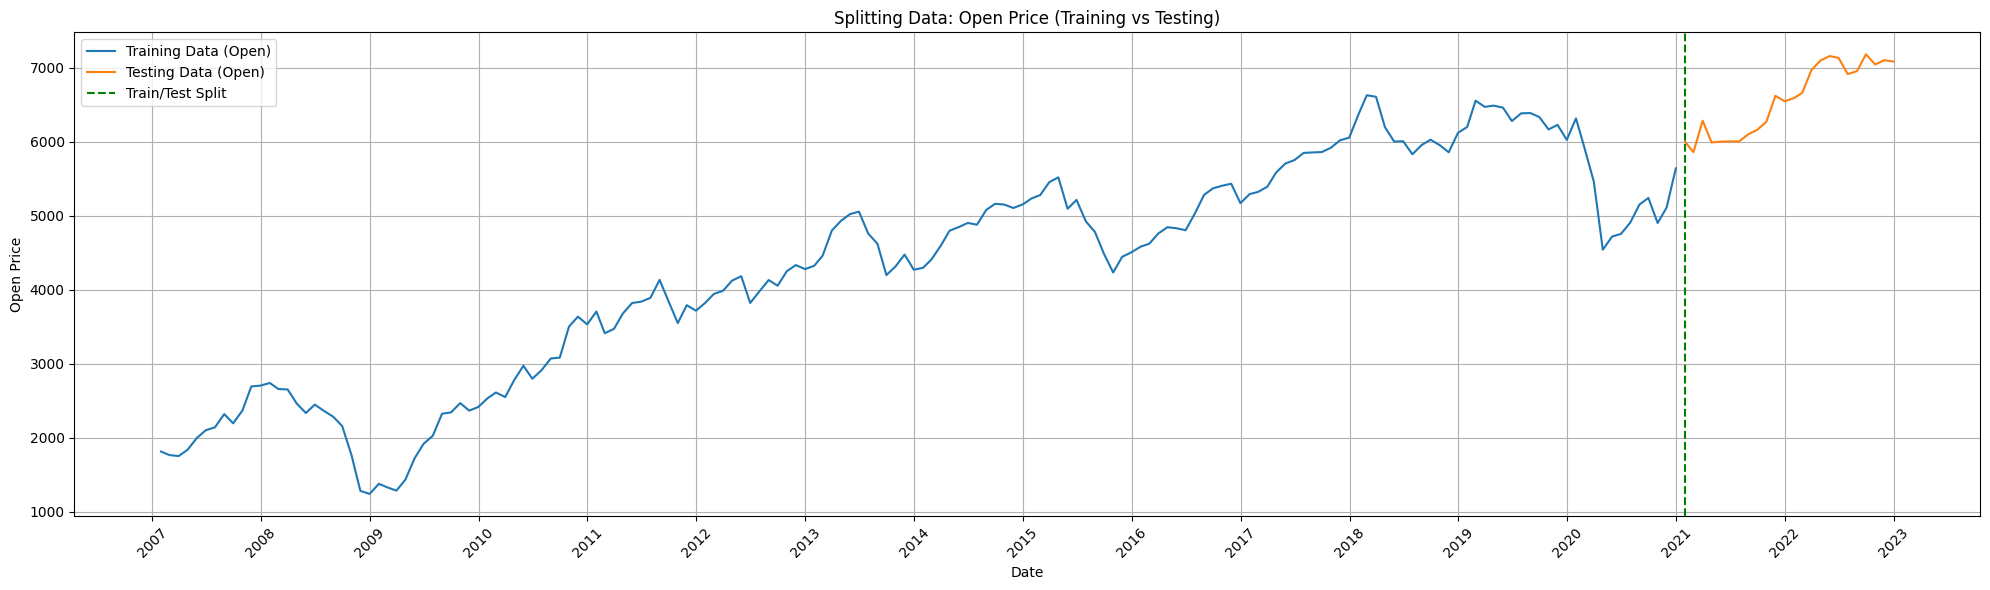

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))
plt.plot(y_train_open.index, y_train_open, label='Training Data (Open)')
plt.plot(y_test_open.index, y_test_open, label='Testing Data (Open)')
plt.axvline(x=y_test_open.index[0], color='green', linestyle='--', label='Train/Test Split')

# Format sumbu x agar menampilkan semua tahun
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title('Splitting Data: Open Price (Training vs Testing)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Display the first 10 rows of the training data
print("Training Data (first 10 rows):")
print(train.head(12))

# Display the first 10 rows of the testing data
print("\nTesting Data (first 10 rows):")
print(test.head(12))


Training Data (first 10 rows):
              Close     Open
Date                        
2007-01-31  1757.26  1813.45
2007-02-28  1740.97  1765.87
2007-03-31  1830.92  1752.11
2007-04-30  1999.17  1837.18
2007-05-31  2084.32  1995.17
2007-06-30  2139.28  2100.68
2007-07-31  2348.67  2140.62
2007-08-31  2194.34  2318.70
2007-09-30  2359.21  2194.43
2007-10-31  2643.49  2366.61
2007-11-30  2688.33  2692.51
2007-12-31  2745.83  2703.72

Testing Data (first 10 rows):
              Close     Open
Date                        
2021-01-31  5862.35  5997.83
2021-02-28  6241.80  5856.78
2021-03-31  5985.52  6281.86
2021-04-30  5995.62  5988.02
2021-05-31  5947.46  5999.66
2021-06-30  5985.49  6002.48
2021-07-31  6070.04  6001.12
2021-08-31  6150.30  6098.01
2021-09-30  6286.94  6157.82
2021-10-31  6591.35  6269.24
2021-11-30  6533.93  6618.12
2021-12-31  6581.48  6544.52


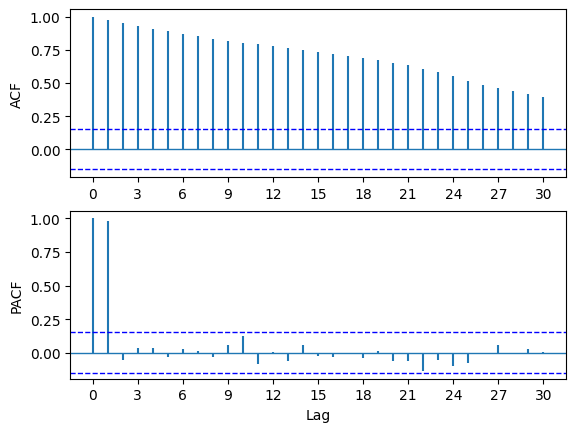

In [16]:
#Plot acf dan pacf data train close
acf_pacf_fig(y_train, both=True, lag=30); plt.show()


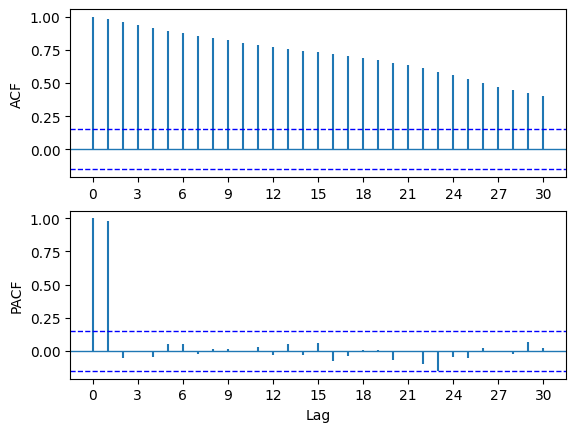

In [17]:
#Plot acf dan pacf data train open
acf_pacf_fig(y_train_open, both=True, lag=30); plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

# === ADF untuk data Close ===
print("=== ADF Test - Data Train Close ===")
result_close = adfuller(y_train, autolag='AIC')
print("ADF Statistic:", result_close[0])
print("p-value:", result_close[1])
print("Critical Values:")
for key, value in result_close[4].items():
    print(f"   {key}: {value}")
print("Kesimpulan:", "Stasioner" if result_close[1] < 0.05 else "Tidak Stasioner")
print()

# === ADF untuk data Open ===
print("=== ADF Test - Data Train Open ===")
result_open = adfuller(y_train_open, autolag='AIC')
print("ADF Statistic:", result_open[0])
print("p-value:", result_open[1])
print("Critical Values:")
for key, value in result_open[4].items():
    print(f"   {key}: {value}")
print("Kesimpulan:", "Stasioner" if result_open[1] < 0.05 else "Tidak Stasioner")

=== ADF Test - Data Train Close ===
ADF Statistic: -1.4771318106428537
p-value: 0.544792056813405
Critical Values:
   1%: -3.4703698981001665
   5%: -2.8791138497902193
   10%: -2.576139407751488
Kesimpulan: Tidak Stasioner

=== ADF Test - Data Train Open ===
ADF Statistic: -1.5282813132861193
p-value: 0.519477491171758
Critical Values:
   1%: -3.4703698981001665
   5%: -2.8791138497902193
   10%: -2.576139407751488
Kesimpulan: Tidak Stasioner


# STASIONERITAS

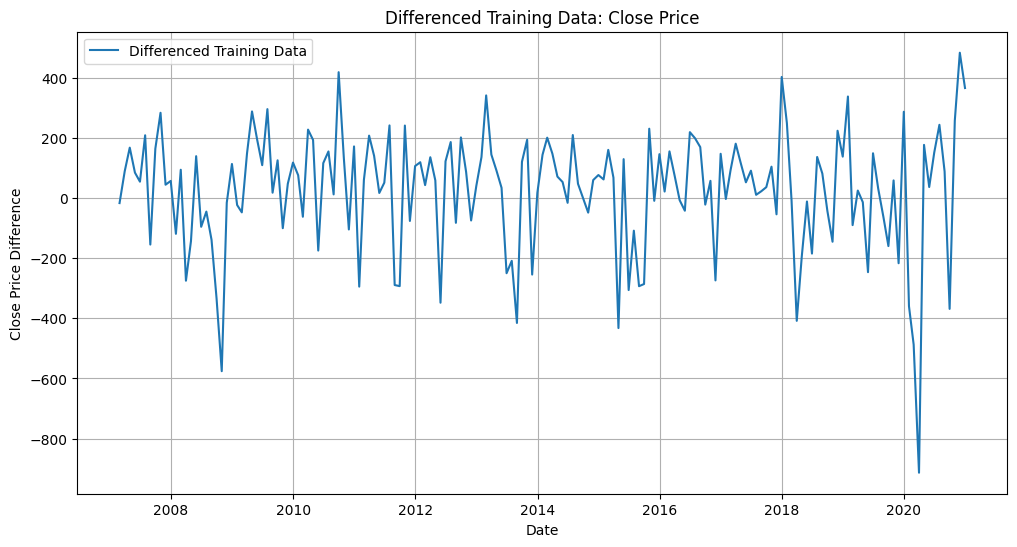

p-value (differenced data): 7.218780747565434e-19


In [19]:
# prompt: lakukan differencing data y_train

import matplotlib.pyplot as plt
# Calculate the difference of the y_train series
y_train_diff = y_train.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(y_train_diff.index, y_train_diff, label='Differenced Training Data')
plt.title('Differenced Training Data: Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price Difference')
plt.legend()
plt.grid(True)
plt.show()

# Perform ADF test on the differenced data
result_diff = adfuller(y_train_diff, autolag='AIC')
p_value_diff = float(result_diff[1])
print("p-value (differenced data):", p_value_diff)


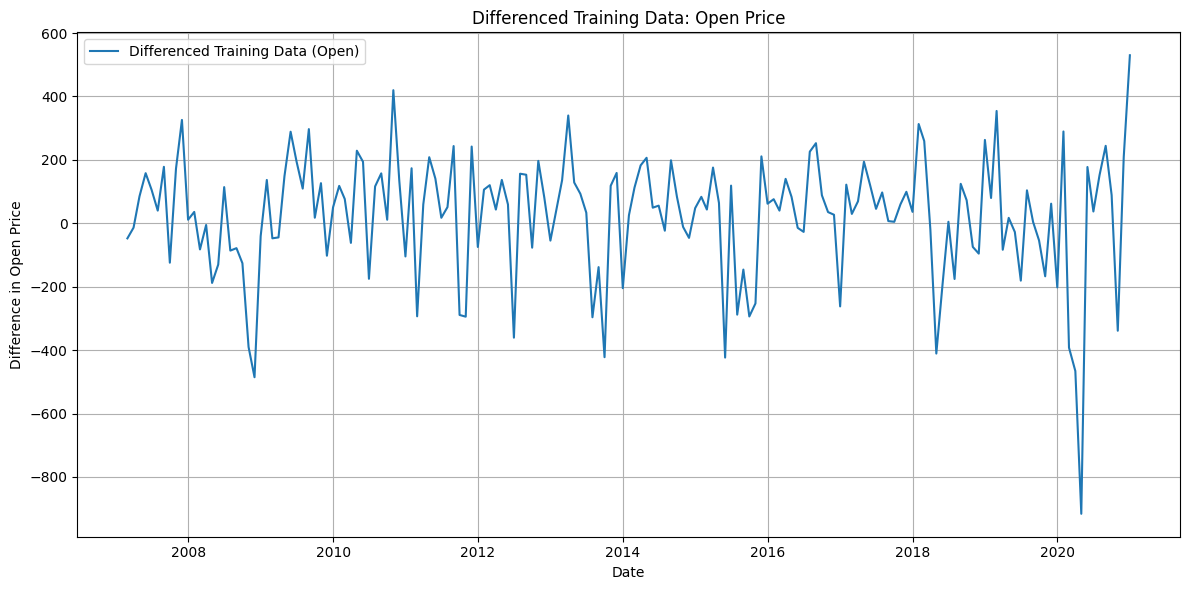

=== ADF Test - Data Train Open (After Differencing) ===
ADF Statistic: -10.339299348143738
p-value: 2.711561656401309e-18
Kesimpulan: Stasioner


In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# === 1. Differencing pada data Open ===
y_train_open_diff = y_train_open.diff().dropna()

# === 2. Plot data setelah differencing ===
plt.figure(figsize=(12, 6))
plt.plot(y_train_open_diff.index, y_train_open_diff, label='Differenced Training Data (Open)')
plt.title('Differenced Training Data: Open Price')
plt.xlabel('Date')
plt.ylabel('Difference in Open Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. ADF Test pada data hasil differencing ===
print("=== ADF Test - Data Train Open (After Differencing) ===")
result_diff_open = adfuller(y_train_open_diff, autolag='AIC')
print("ADF Statistic:", result_diff_open[0])
print("p-value:", result_diff_open[1])
print("Kesimpulan:", "Stasioner" if result_diff_open[1] < 0.05 else "Tidak Stasioner")

Plot hasil differencing menunjukkan bahwa data sudah stasioner terhadap nilai tengah. Selanjutnya, dilakukan pengecekan lebih lanjut menggunakan plot ACF dan uji ADF.

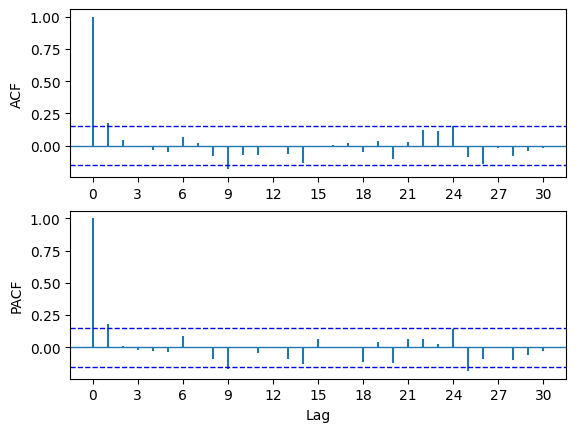

ADF TEST (differenced data): 7.218780747565434e-19


In [21]:
# prompt: PLOT ACF PACF DAN UJI ADF

import matplotlib.pyplot as plt
#Plot acf dan pacf data train
acf_pacf_fig(y_train_diff, both=True, lag=30); plt.show()
#ADF DATA TRAIN CLOSE (Differenced)
result_diff = adfuller(y_train_diff, autolag='AIC')
p_value_diff = float(result_diff[1])
print("ADF TEST (differenced data):", p_value_diff)


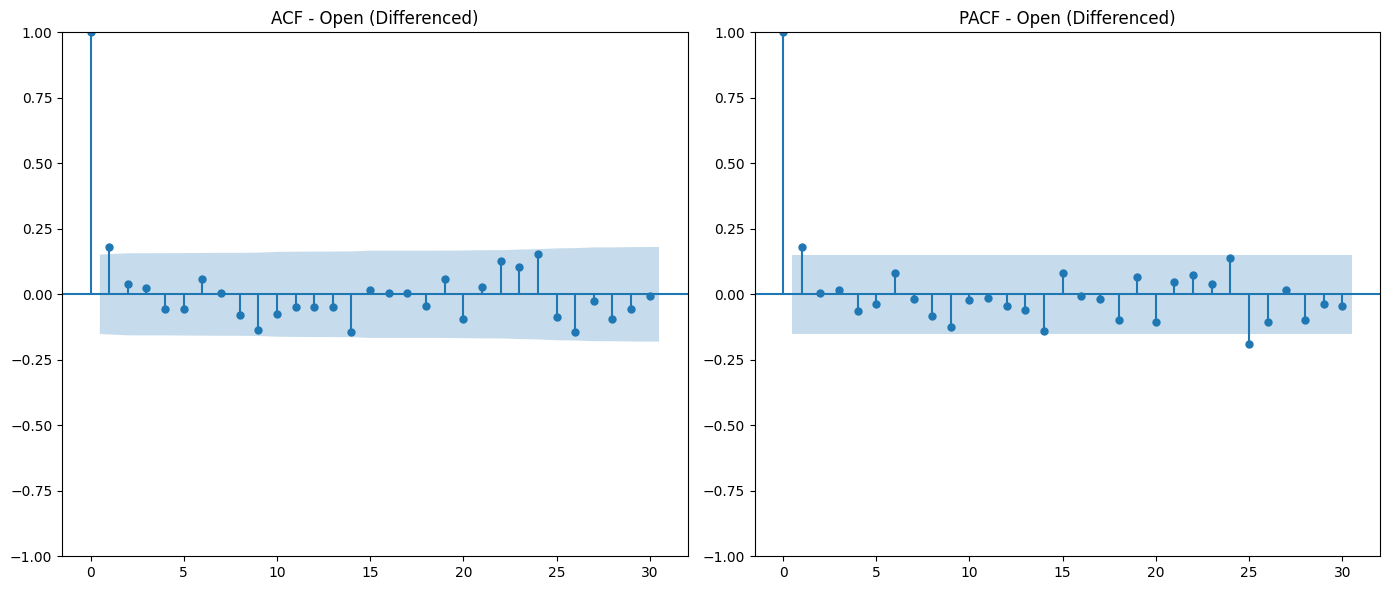

=== ADF TEST (Open - Differenced) ===
ADF Statistic: -10.339299348143738
p-value: 2.711561656401309e-18
Kesimpulan: Stasioner


In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# === Differencing data Open ===
y_train_open_diff = y_train_open.diff().dropna()

# === Plot ACF dan PACF untuk data differenced Open ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y_train_open_diff, ax=plt.gca(), lags=30)
plt.title('ACF - Open (Differenced)')

plt.subplot(1, 2, 2)
plot_pacf(y_train_open_diff, ax=plt.gca(), lags=30, method='ywm')
plt.title('PACF - Open (Differenced)')

plt.tight_layout()
plt.show()

# === Uji ADF pada data Open setelah differencing ===
result_open_diff = adfuller(y_train_open_diff, autolag='AIC')
print("=== ADF TEST (Open - Differenced) ===")
print("ADF Statistic:", result_open_diff[0])
print("p-value:", result_open_diff[1])
print("Kesimpulan:", "Stasioner" if result_open_diff[1] < 0.05 else "Tidak Stasioner")

Berdasarkan plot ACF yang menunjukkan pola cut-off pada lag 1, dapat disimpulkan bahwa data sudah stasioner terhadap nilai tengah. Nilai ADF < 0.05 sehingga data stasioner terhadap nilai tengah

Lambda Box-Cox (setelah differencing): 1.7927096932498767


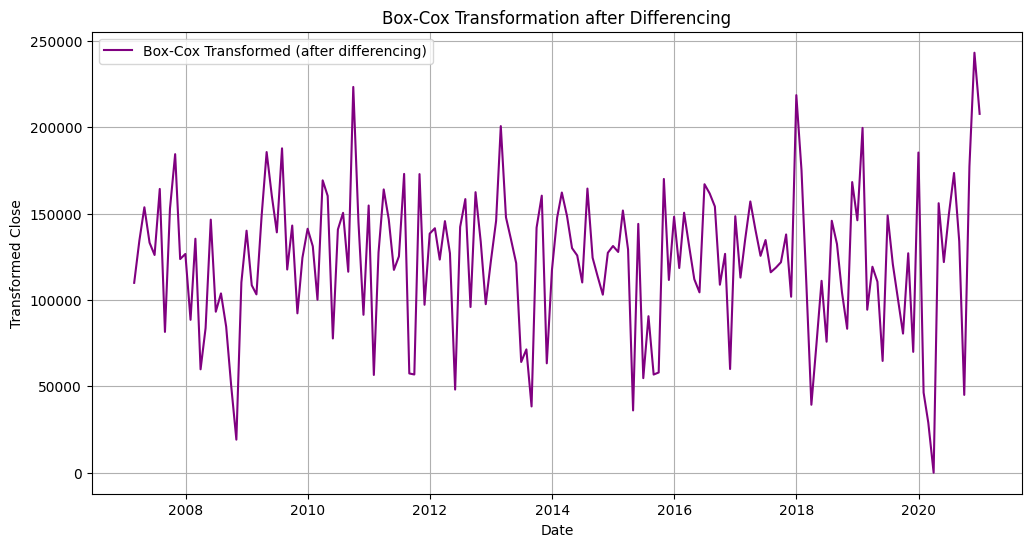

In [23]:
from scipy.stats import boxcox, boxcox_normmax
import matplotlib.pyplot as plt

# Geser data differenced agar semua nilai > 0
y_diff_shifted = y_train_diff + abs(min(y_train_diff)) + 1

# Estimasi lambda terbaik
lambda_boxcox_diff = boxcox_normmax(y_diff_shifted, method='mle')
print("Lambda Box-Cox (setelah differencing):", lambda_boxcox_diff)

# Transformasi Box-Cox
y_diff_boxcox = boxcox(y_diff_shifted, lmbda=lambda_boxcox_diff)

# Plot hasil transformasi Box-Cox
plt.figure(figsize=(12, 6))
plt.plot(y_train_diff.index, y_diff_boxcox, label='Box-Cox Transformed (after differencing)', color='purple')
plt.title('Box-Cox Transformation after Differencing')
plt.xlabel('Date')
plt.ylabel('Transformed Close')
plt.legend()
plt.grid(True)
plt.show()

Lambda Box-Cox (Open - setelah differencing): 1.7570410822449896


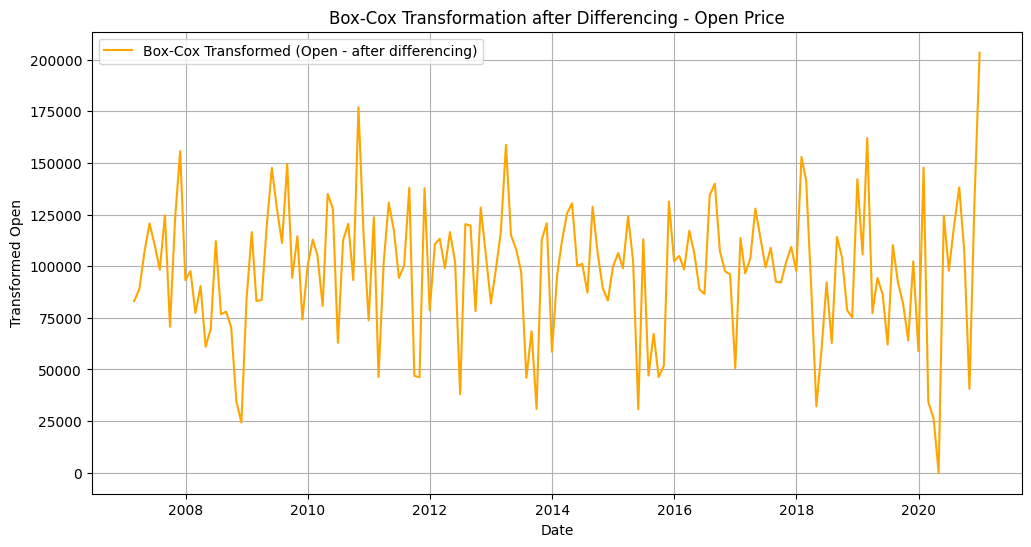

In [24]:
from scipy.stats import boxcox, boxcox_normmax
import matplotlib.pyplot as plt

# Lakukan differencing data Open
y_train_open_diff = y_train_open.diff().dropna()

# Geser data agar semua nilai > 0 sebelum transformasi Box-Cox
y_open_diff_shifted = y_train_open_diff + abs(min(y_train_open_diff)) + 1

# Estimasi nilai lambda terbaik untuk Box-Cox
lambda_boxcox_open = boxcox_normmax(y_open_diff_shifted, method='mle')
print("Lambda Box-Cox (Open - setelah differencing):", lambda_boxcox_open)

# Transformasi Box-Cox pada data yang sudah di-shift
y_open_boxcox = boxcox(y_open_diff_shifted, lmbda=lambda_boxcox_open)

# Plot hasil transformasi Box-Cox
plt.figure(figsize=(12, 6))
plt.plot(y_train_open_diff.index, y_open_boxcox, label='Box-Cox Transformed (Open - after differencing)', color='orange')
plt.title('Box-Cox Transformation after Differencing - Open Price')
plt.xlabel('Date')
plt.ylabel('Transformed Open')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from statsmodels.stats.diagnostic import het_arch

# Uji ARCH pada data Close
arch_test_close = het_arch(y_train_diff)
stat_close = arch_test_close[0]
pval_close = arch_test_close[1]

print("=== Uji ARCH - Close ===")
print(f"Statistik ARCH: {stat_close}")
print(f"p-value: {pval_close}")
if pval_close < 0.05:
    print("Terdapat gejala heteroskedastisitas pada Close.\n")
else:
    print("Tidak terdapat gejala heteroskedastisitas pada Close.\n")

# Uji ARCH pada data Open
y_train_open_diff = y_train_open.diff().dropna()
arch_test_open = het_arch(y_train_open_diff)
stat_open = arch_test_open[0]
pval_open = arch_test_open[1]

print("=== Uji ARCH - Open ===")
print(f"Statistik ARCH: {stat_open}")
print(f"p-value: {pval_open}")
if pval_open < 0.05:
    print("Terdapat gejala heteroskedastisitas pada Open.")
else:
    print("Tidak terdapat gejala heteroskedastisitas pada Open.")

=== Uji ARCH - Close ===
Statistik ARCH: 12.401623110107925
p-value: 0.25907598122432235
Tidak terdapat gejala heteroskedastisitas pada Close.

=== Uji ARCH - Open ===
Statistik ARCH: 12.981241234126943
p-value: 0.2247225327021143
Tidak terdapat gejala heteroskedastisitas pada Open.



Untuk mengecek kestasioneran terhadap ragam, dilakukan analisis terhadap nilai lambda menggunakan transformasi Box-Cox. Sebelum transformasi dilakukan, ditambahkan konstanta pada data karena metode Box-Cox tidak dapat diterapkan pada data yang mengandung nilai nol atau negatif. Hasil transformasi menunjukkan bahwa nilai lambda sebesar 1, yang mengindikasikan bahwa data telah stasioner terhadap ragam. Hal ini diperkuat oleh hasil uji ARCH, di mana p-value yang diperoleh lebih besar dari 0.05, sehingga tidak terdapat indikasi adanya gejala heteroskedastisitas.”


# ARIMA

## IDENTIFIKASI MODEL TERBAIK

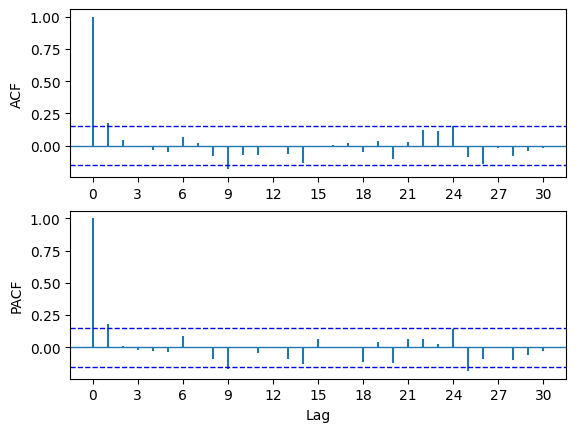

In [26]:
# prompt: plot acf dan pacf hasil differencing CLOSE

import matplotlib.pyplot as plt
# Plot ACF and PACF of the differenced data
acf_pacf_fig(y_train_diff, both=True, lag=30); plt.show()


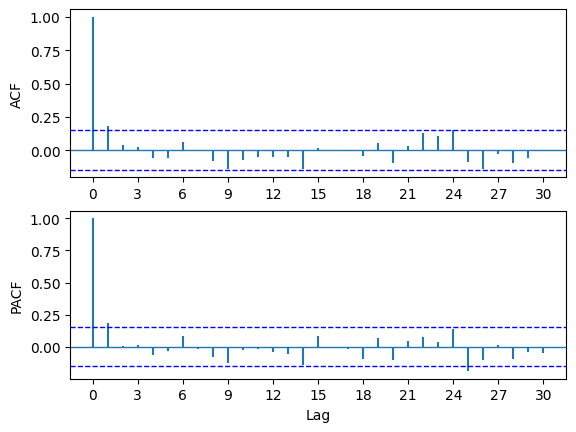

In [27]:
# prompt: plot acf dan pacf hasil differencing OPEN

import matplotlib.pyplot as plt
# Plot ACF and PACF of the differenced data
acf_pacf_fig(y_train_open_diff, both=True, lag=30); plt.show()

Plot ACF yang menunjukkan cut-off di lag 1 mengindikasikan adanya komponen MA(1). Sementara itu, plot PACF yang mengalami cut-off di lag 1 AR(1).
Dari hasil tersebut, maka model tentatif yang dapat di uji adalah
*   ARIMA (0,1,1)
*   ARIMA (1,1,0)

## ARIMA (0,1,1)

In [28]:
#MODEL MA(1) CLOSE
model_ma1 = ARIMA(y_train_diff, order=(0,0,1)).fit()
print(model_ma1.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  167
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1118.816
Date:                Sun, 04 May 2025   AIC                           2243.633
Time:                        07:11:26   BIC                           2252.987
Sample:                    02-28-2007   HQIC                          2247.430
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.3645     20.494      1.238      0.216     -14.803      65.532
ma.L1          0.1688      0.066      2.565      0.010       0.040       0.298
sigma2       3.86e+04   3761.051     10.262      0.0

In [29]:
#MODEL MA(1) OPEN
model_ma1open = ARIMA(y_train_open_diff, order=(0,0,1)).fit()
print(model_ma1open.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  167
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1113.364
Date:                Sun, 04 May 2025   AIC                           2232.727
Time:                        07:11:35   BIC                           2242.081
Sample:                    02-28-2007   HQIC                          2236.524
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0584     19.747      1.168      0.243     -15.646      61.763
ma.L1          0.1820      0.064      2.849      0.004       0.057       0.307
sigma2      3.615e+04   3248.048     11.130      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


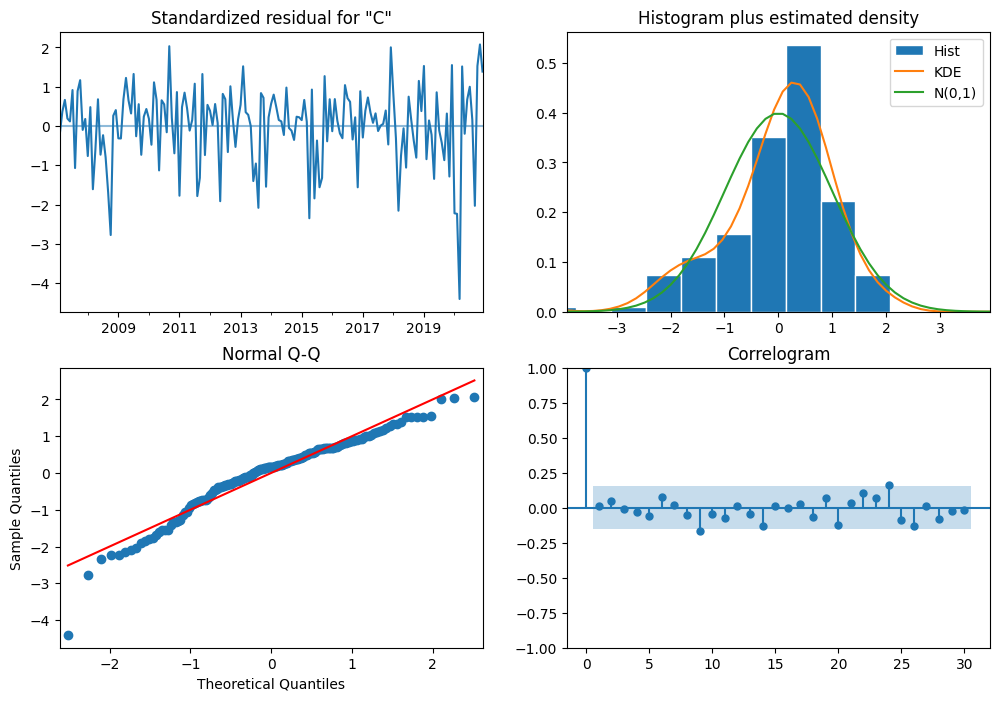


=== UJI STATISTIK RESIDUAL (MA1) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.16102990618684912
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 32.226658408545866 p-value: 0.3570614124083846
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9494019576393283 p-value: 1.0595950887404607e-05
Uji Normalitas (Jarque-Bera) - JB Statistic: 45.87015187621783 p-value: 1.0950225885095515e-10


In [30]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL MA CLOSE===
model_ma1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (MA1) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ma1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ma1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ma1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ma1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)


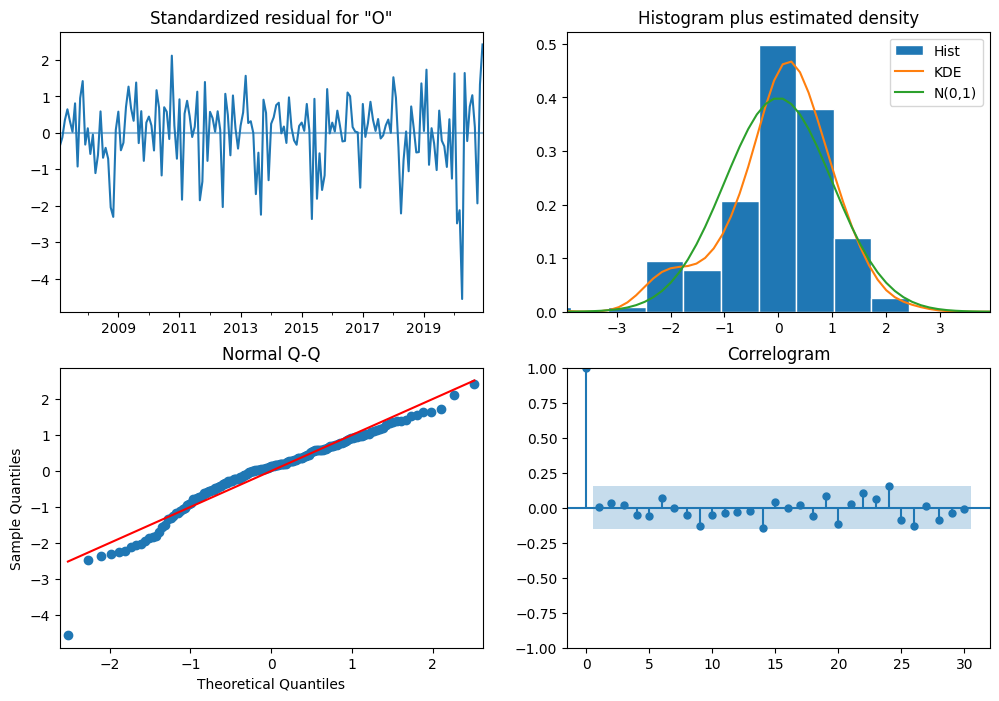


=== UJI STATISTIK RESIDUAL (MA(1) OPEN) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.0871514507861401
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 30.90270011460655 p-value: 0.4202018607082446
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9508261242996532 p-value: 1.4141975723385305e-05
Uji Normalitas (Jarque-Bera) - JB Statistic: 55.159099341157585 p-value: 1.052819122981083e-12


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ma1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (MA(1) OPEN) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ma1open.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ma1open.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ma1open.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ma1open.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)

## ARIMA (1,1,0)

In [32]:
#MODEL AR(1)
model_ar1 = ARIMA(y_train_diff, order=(1,0,0)).fit()
print(model_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  167
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1118.660
Date:                Sun, 04 May 2025   AIC                           2243.321
Time:                        07:12:22   BIC                           2252.675
Sample:                    02-28-2007   HQIC                          2247.117
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4180     21.324      1.192      0.233     -16.376      67.212
ar.L1          0.1795      0.062      2.899      0.004       0.058       0.301
sigma2      3.852e+04   3900.704      9.874      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


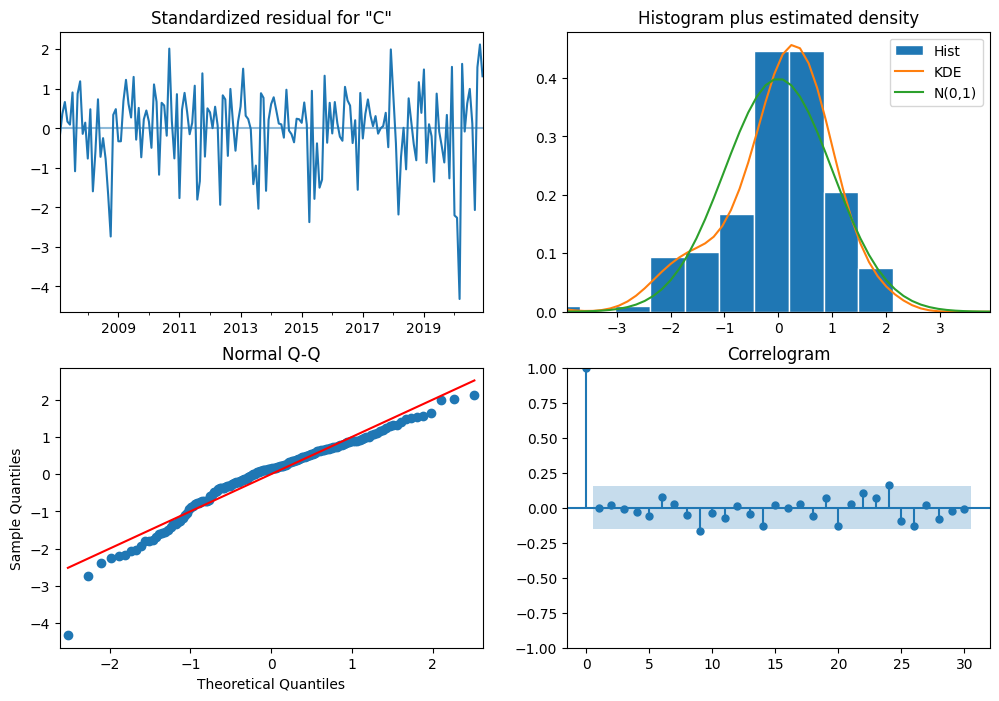


=== UJI STATISTIK RESIDUAL (AR1) ===
Uji Autokorelasi (ARCH Test) - p-value: 0.10465715089151538
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 31.862521838109497 p-value: 0.37394849446766104
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9538520999704884 p-value: 2.6490515455644255e-05
Uji Normalitas (Jarque-Bera) - JB Statistic: 39.78678384185817 p-value: 2.293029607731748e-09


In [33]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ar1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (AR1) ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ar1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ar1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ar1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)


In [34]:
#MODEL AR(1) OPEN
model_ar1open = ARIMA(y_train_open_diff, order=(1,0,0)).fit()
print(model_ar1open.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  167
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1113.246
Date:                Sun, 04 May 2025   AIC                           2232.492
Time:                        07:12:32   BIC                           2241.846
Sample:                    02-28-2007   HQIC                          2236.289
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.1234     20.606      1.122      0.262     -17.263      63.510
ar.L1          0.1890      0.061      3.120      0.002       0.070       0.308
sigma2      3.609e+04   3396.640     10.624      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


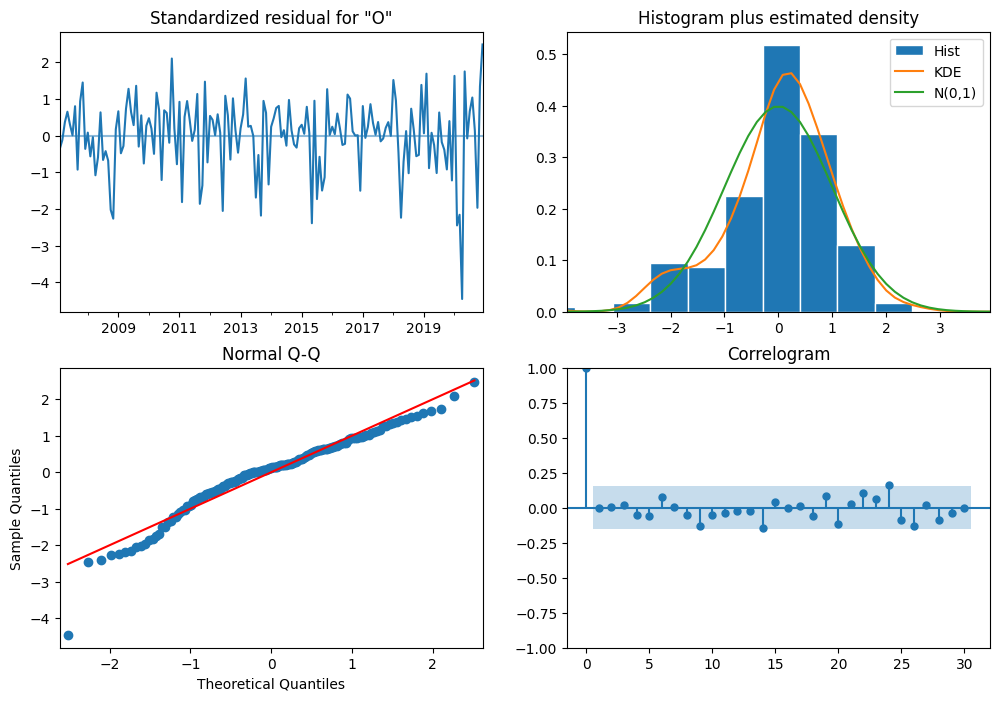


=== UJI STATISTIK RESIDUAL (AR1)OPEN ===
Uji Autokorelasi (ARCH Test) - p-value: 0.10465715089151538
Uji Keacakan Residual (Ljung-Box Test) - Statistic: 31.862521838109497 p-value: 0.37394849446766104
Uji Normalitas (Shapiro-Wilk) - Statistic: 0.9538520999704884 p-value: 2.6490515455644255e-05
Uji Normalitas (Jarque-Bera) - JB Statistic: 39.78678384185817 p-value: 2.293029607731748e-09


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro, jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf

# === 1. PLOT DIAGNOSTIK RESIDUAL ===
model_ar1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.show()

# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (AR1)OPEN ===")

# 2.1 UJI AUTOKORELASI (ARCH Test)
arch_pvalue = het_arch(model_ar1.resid, nlags=10)[1]
print("Uji Autokorelasi (ARCH Test) - p-value:", arch_pvalue)

# 2.2 UJI KEACAKAN (Ljung-Box Test)
ljungbox_result = acorr_ljungbox(model_ar1.resid, lags=[30], return_df=True)
print("Uji Keacakan Residual (Ljung-Box Test) - Statistic:", ljungbox_result['lb_stat'].values[0],
      "p-value:", ljungbox_result['lb_pvalue'].values[0])

# 2.3 UJI NORMALITAS (Shapiro-Wilk)
shapiro_stat, shapiro_pval = shapiro(model_ar1.resid)
print("Uji Normalitas (Shapiro-Wilk) - Statistic:", shapiro_stat, "p-value:", shapiro_pval)

# 2.4 UJI NORMALITAS (Jarque-Bera)
jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print("Uji Normalitas (Jarque-Bera) - JB Statistic:", jb_stat, "p-value:", jb_pval)

Kesimpulan Model (0,1,1) dan (1,1,0)

Memenuhi Asumsi:

	* Homoskedastisitas → Varians residual konstan (p-value > 0.05) tidak ada heteroskedastisitas.
	* Tidak ada autokorelasi signifikan → p-value > 0.05, sehingga gagal menolak H₀, yang berarti residual bersifat white noise.
	* Residual acak → p-value > 0.05, sehingga residual dianggap acak tanpa pola sistematis.

Tidak Memenuhi Asumsi:

	* Normalitas residual tidak terpenuhi → Uji Shapiro-Wilk dan Jarque-Bera menunjukkan p-value < 0.05, sehingga H₀ ditolak dan residual tidak berdistribusi normal.
	* Namun, karena jumlah data besar, berdasarkan Dalil Limit Pusat, asumsi normalitas dapat diabaikan.

Kesimpulannya Model (0,1,1) dan (1,1,0) dapat digunakan untuk baselin analisis time series.

In [36]:
import pandas as pd

# Create a DataFrame to store AIC and BIC values
results_df = pd.DataFrame(columns=['Model', 'AIC', 'BIC'])

# Append MA(1) model results
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'MA(1)', 'AIC': model_ma1.aic, 'BIC': model_ma1.bic}])], ignore_index=True)

# Append AR(1) model results
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'AR(1)', 'AIC': model_ar1.aic, 'BIC': model_ar1.bic}])], ignore_index=True)

# Append MA(1) model results for Open data
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'MA(1) Open', 'AIC': model_ma1open.aic, 'BIC': model_ma1open.bic}])], ignore_index=True)

# Append AR(1) model results for Open data
results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'AR(1) Open', 'AIC': model_ar1open.aic, 'BIC': model_ar1open.bic}])], ignore_index=True)

# Display the DataFrame
print(results_df)

        Model          AIC          BIC
0       MA(1)  2243.632984  2252.986966
1       AR(1)  2243.320775  2252.674756
2  MA(1) Open  2232.727211  2242.081192
3  AR(1) Open  2232.492102  2241.846083


<ipython-input-36-10422a32f709>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Model': 'MA(1)', 'AIC': model_ma1.aic, 'BIC': model_ma1.bic}])], ignore_index=True)


Berdasarkan nilai AIC dan BIC  dari pemilihan model tentatif, model terbaik adalah Model AR(1) untuk data CLOSE dan OPEN

#OVERFITTING MODEL ARIMA
Model yang dilakukan overfitting ARIMA (1,1,0) data CLOSE dan OPEN

*   ARIMAX (1,1,1)
*   ARIMAX (2,1,1)
*   ARIMAX (2,1,0)


In [37]:
#MODEL ARIMA(1,1,1)
model_arima1 = ARIMA(y_train_diff, order=(1,0,1)).fit()
print(model_arima1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  167
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1118.648
Date:                Sun, 04 May 2025   AIC                           2245.296
Time:                        07:15:03   BIC                           2257.768
Sample:                    02-28-2007   HQIC                          2250.358
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4386     21.686      1.173      0.241     -17.065      67.942
ar.L1          0.2394      0.411      0.583      0.560      -0.566       1.045
ma.L1         -0.0616      0.430     -0.143      0.8

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


In [38]:
#MODEL ARIMA(1,1,1) OPEN
model_arima1open = ARIMA(y_train_open_diff, order=(1,0,1)).fit()
print(model_arima1open.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  167
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1113.242
Date:                Sun, 04 May 2025   AIC                           2234.483
Time:                        07:15:17   BIC                           2246.955
Sample:                    02-28-2007   HQIC                          2239.545
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.1126     20.941      1.104      0.270     -17.932      64.157
ar.L1          0.2284      0.366      0.624      0.533      -0.489       0.946
ma.L1         -0.0407      0.384     -0.106      0.9

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


In [39]:
#MODEL ARIMA(2,1,1)
model_arima21 = ARIMA(y_train_diff, order=(2,0,1)).fit()
print(model_arima21.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found.

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  167
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1118.520
Date:                Sun, 04 May 2025   AIC                           2247.041
Time:                        07:15:24   BIC                           2262.631
Sample:                    02-28-2007   HQIC                          2253.368
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4324     21.597      1.178      0.239     -16.896      67.761
ar.L1         -0.6600      0.623     -1.060      0.289      -1.881       0.561
ar.L2          0.1725      0.111      1.558      0.1

In [40]:
#MODEL ARIMA(2,1,1) OPEN
model_arima21open = ARIMA(y_train_open_diff, order=(2,0,1)).fit()
print(model_arima21open.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found.

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  167
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1111.096
Date:                Sun, 04 May 2025   AIC                           2232.192
Time:                        07:16:00   BIC                           2247.782
Sample:                    02-28-2007   HQIC                          2238.520
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3497      6.895      3.822      0.000      12.837      39.863
ar.L1          1.1652      0.074     15.741      0.000       1.020       1.310
ar.L2         -0.2241      0.068     -3.282      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
#MODEL ARIMA(2,1,0)
model_arima2 = ARIMA(y_train_diff, order=(2,0,0)).fit()
print(model_arima2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  167
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1118.645
Date:                Sun, 04 May 2025   AIC                           2245.290
Time:                        07:16:13   BIC                           2257.762
Sample:                    02-28-2007   HQIC                          2250.352
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4395     21.720      1.171      0.241     -17.130      68.009
ar.L1          0.1773      0.065      2.736      0.006       0.050       0.304
ar.L2          0.0138      0.075      0.185      0.8

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


In [42]:
#MODEL ARIMA(2,1,0)OPEN
model_arima2open = ARIMA(y_train_diff, order=(2,0,0)).fit()
print(model_arima2open.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  167
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1118.645
Date:                Sun, 04 May 2025   AIC                           2245.290
Time:                        07:16:44   BIC                           2257.762
Sample:                    02-28-2007   HQIC                          2250.352
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4395     21.720      1.171      0.241     -17.130      68.009
ar.L1          0.1773      0.065      2.736      0.006       0.050       0.304
ar.L2          0.0138      0.075      0.185      0.8

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BME will be used.
  self._init_dates(dates, freq)


## UJI DIAGNOSTIK MODEL

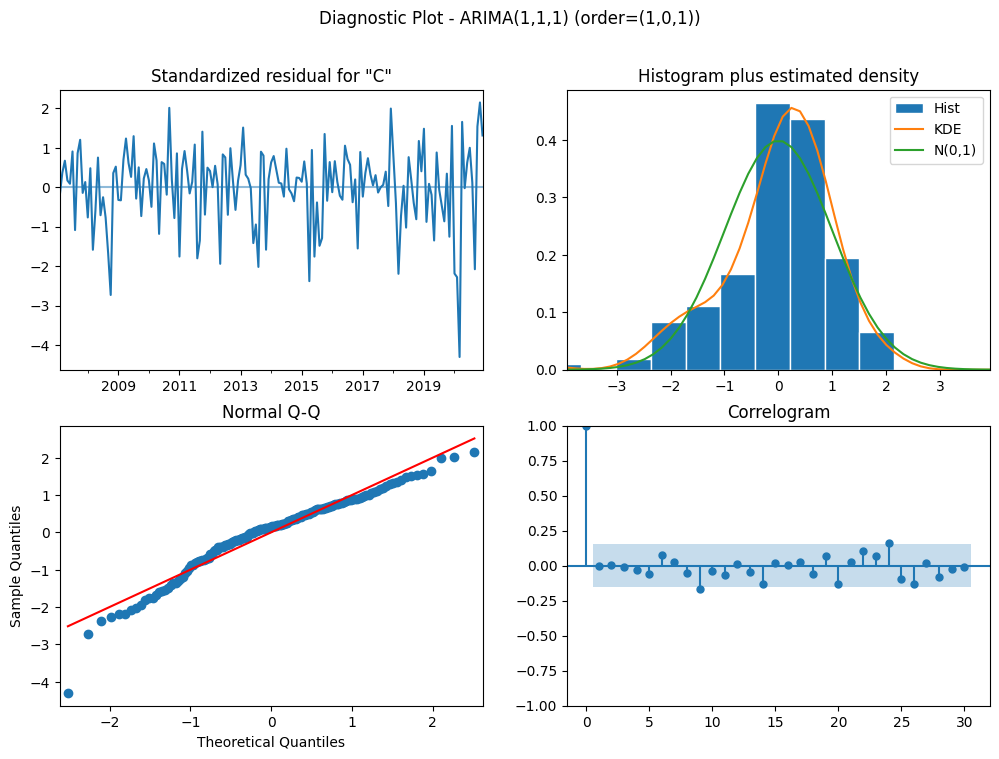

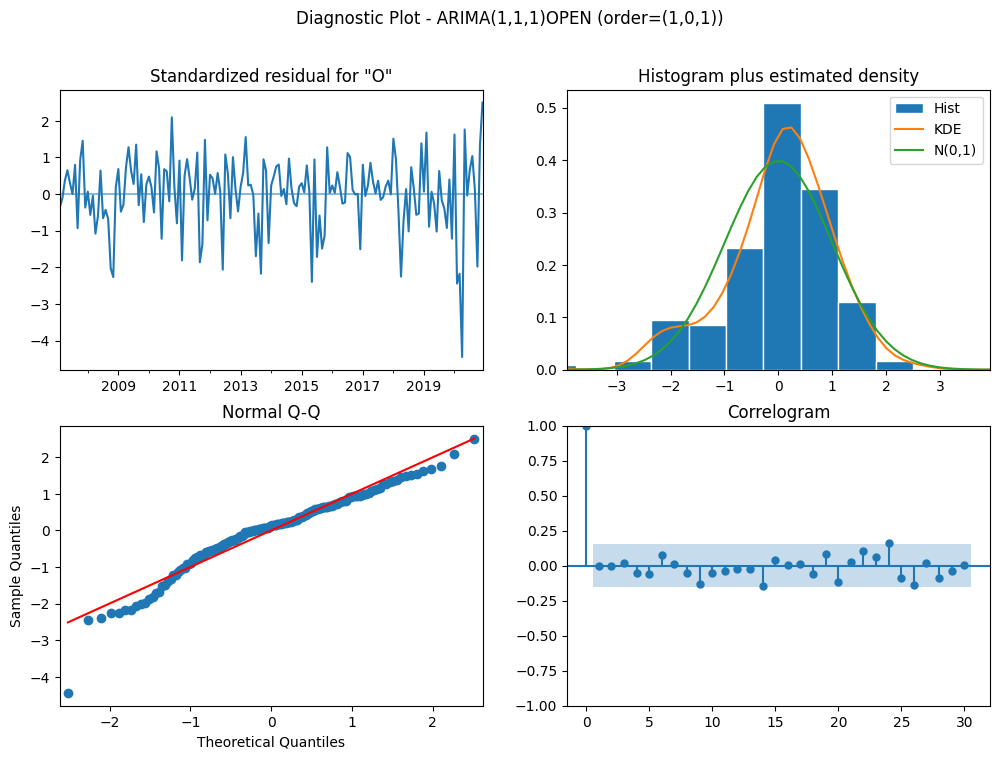

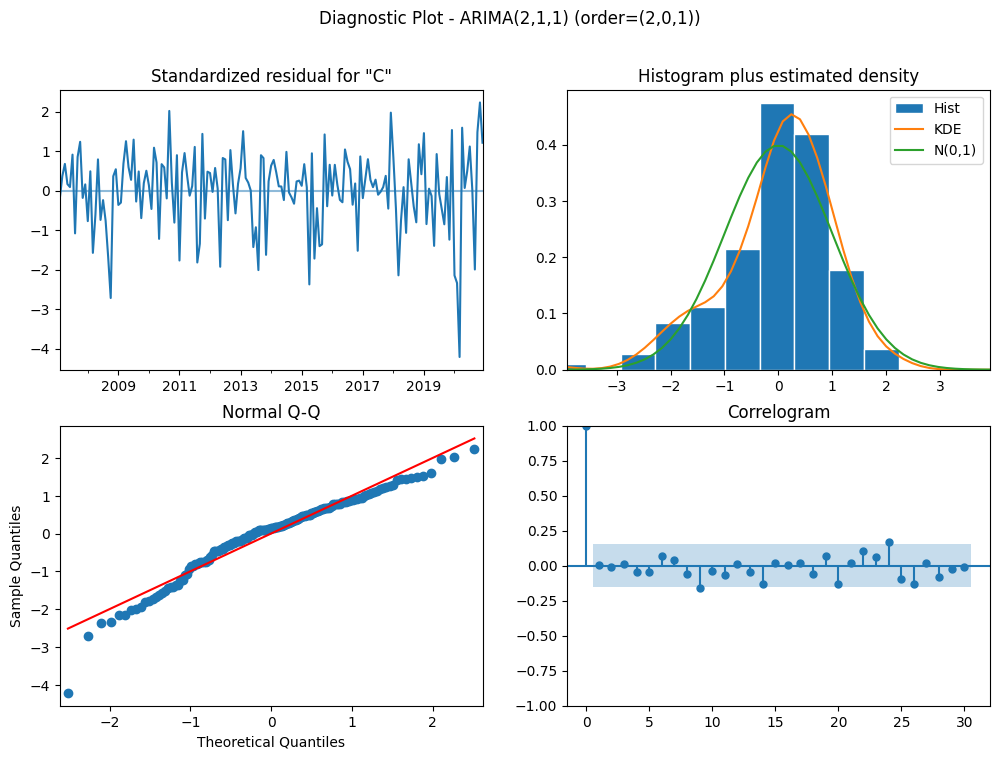

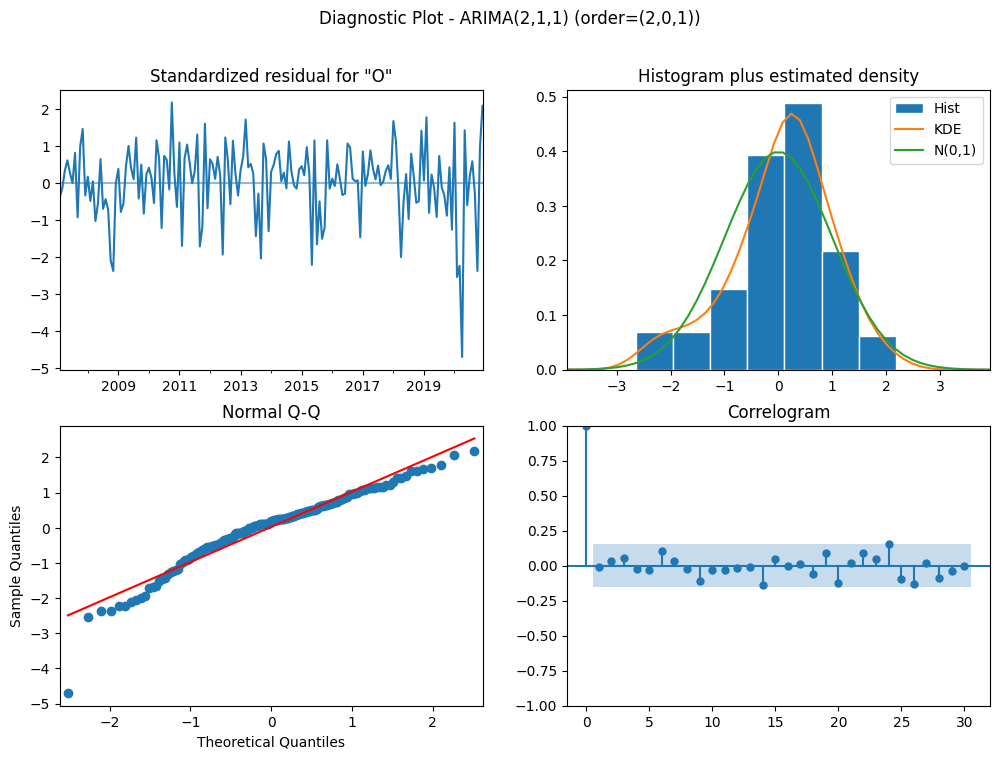

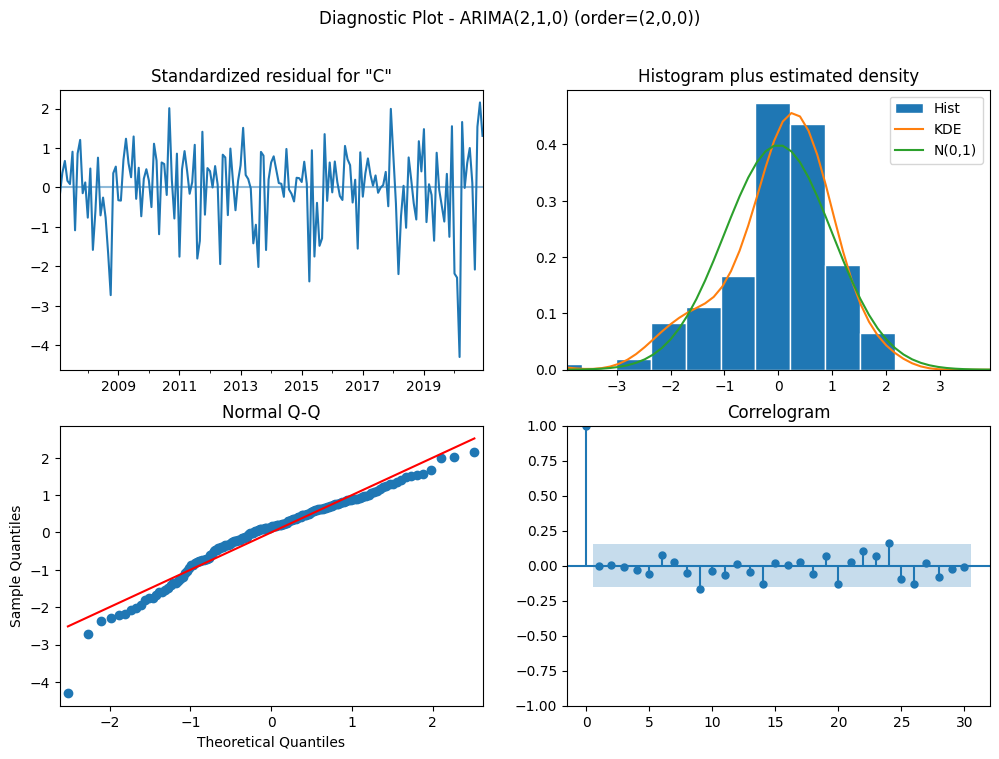

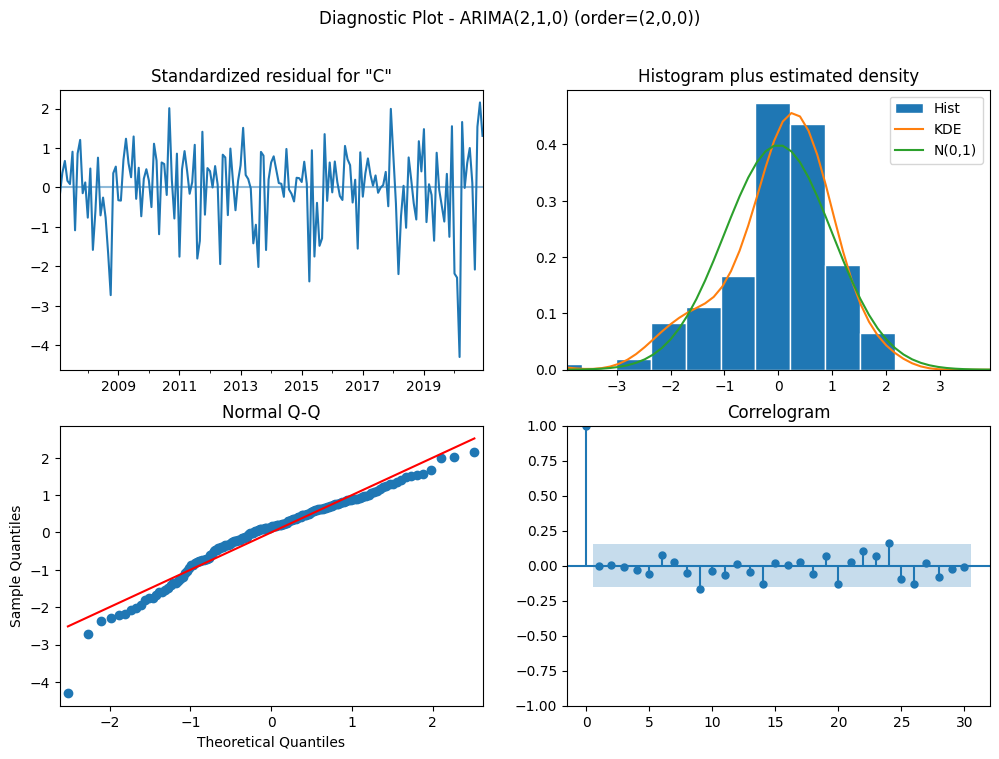

In [43]:
# === 1. PLOT DIAGNOSTIK RESIDUAL ===

# ARIMA(1,1,1)
model_arima1.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(1,1,1) (order=(1,0,1))")
plt.show()

# ARIMA(1,1,1) OPEN
model_arima1open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(1,1,1)OPEN (order=(1,0,1))")
plt.show()

# ARIMA(2,1,1)
model_arima21.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(2,1,1) (order=(2,0,1))")
plt.show()

# ARIMA(2,1,1) OPEN
model_arima21open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(2,1,1) (order=(2,0,1))")
plt.show()

# ARIMA(2,1,0)
model_arima2.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(2,1,0) (order=(2,0,0))")
plt.show()

# ARIMA(2,1,0)OPEN
model_arima2open.plot_diagnostics(figsize=(12, 8), lags=30)
plt.suptitle("Diagnostic Plot - ARIMA(2,1,0) (order=(2,0,0))")
plt.show()

In [45]:
# === 2. UJI STATISTIK RESIDUAL ===
print("\n=== UJI STATISTIK RESIDUAL (ARIMA dengan y_train_diff) ===")

# --- ARIMA(1,1,1) ---
print("\n--- Model ARIMA(1,1,1) (order=(1,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima1.resid, nlags=10)[1])
ljungbox_1 = acorr_ljungbox(model_arima1.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_1['lb_stat'].values[0],
      "p-value:", ljungbox_1['lb_pvalue'].values[0])
shapiro_stat_1, shapiro_pval_1 = shapiro(model_arima1.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_1, "p-value:", shapiro_pval_1)
jb_stat_1, jb_pval_1 = jarque_bera(model_arima1.resid)
print("Jarque-Bera - Statistic:", jb_stat_1, "p-value:", jb_pval_1)

# --- ARIMA(1,1,1) OPEN---
print("\n--- Model ARIMA(1,1,1) OPEN (order=(1,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima1open.resid, nlags=10)[1])
ljungbox_1 = acorr_ljungbox(model_arima1open.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_1['lb_stat'].values[0],
      "p-value:", ljungbox_1['lb_pvalue'].values[0])
shapiro_stat_1, shapiro_pval_1 = shapiro(model_arima1open.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_1, "p-value:", shapiro_pval_1)
jb_stat_1, jb_pval_1 = jarque_bera(model_arima1open.resid)
print("Jarque-Bera - Statistic:", jb_stat_1, "p-value:", jb_pval_1)

# --- ARIMA(2,1,1) ---
print("\n--- Model ARIMA(2,1,1) (order=(2,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima21.resid, nlags=10)[1])
ljungbox_2 = acorr_ljungbox(model_arima21.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_2['lb_stat'].values[0],
      "p-value:", ljungbox_2['lb_pvalue'].values[0])
shapiro_stat_2, shapiro_pval_2 = shapiro(model_arima21.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_2, "p-value:", shapiro_pval_2)
jb_stat_2, jb_pval_2 = jarque_bera(model_arima21.resid)
print("Jarque-Bera - Statistic:", jb_stat_2, "p-value:", jb_pval_2)

# --- ARIMA(2,1,1) OPEN---
print("\n--- Model ARIMA(2,1,1) OPEN (order=(2,0,1)) ---")
print("ARCH Test p-value:", het_arch(model_arima21open.resid, nlags=10)[1])
ljungbox_2 = acorr_ljungbox(model_arima21open.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_2['lb_stat'].values[0],
      "p-value:", ljungbox_2['lb_pvalue'].values[0])
shapiro_stat_2, shapiro_pval_2 = shapiro(model_arima21open.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_2, "p-value:", shapiro_pval_2)
jb_stat_2, jb_pval_2 = jarque_bera(model_arima21open.resid)
print("Jarque-Bera - Statistic:", jb_stat_2, "p-value:", jb_pval_2)

# --- ARIMA(2,1,0) ---
print("\n--- Model ARIMA(2,1,0) (order=(2,0,0)) ---")
print("ARCH Test p-value:", het_arch(model_arima2.resid, nlags=10)[1])
ljungbox_3 = acorr_ljungbox(model_arima2.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_3['lb_stat'].values[0],
      "p-value:", ljungbox_3['lb_pvalue'].values[0])
shapiro_stat_3, shapiro_pval_3 = shapiro(model_arima2.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_3, "p-value:", shapiro_pval_3)
jb_stat_3, jb_pval_3 = jarque_bera(model_arima2.resid)
print("Jarque-Bera - Statistic:", jb_stat_3, "p-value:", jb_pval_3)

# --- ARIMA(2,1,0) OPEN---
print("\n--- Model ARIMA(2,1,0) OPEN (order=(2,0,0)) ---")
print("ARCH Test p-value:", het_arch(model_arima2open.resid, nlags=10)[1])
ljungbox_3 = acorr_ljungbox(model_arima2open.resid, lags=[30], return_df=True)
print("Ljung-Box Test - Statistic:", ljungbox_3['lb_stat'].values[0],
      "p-value:", ljungbox_3['lb_pvalue'].values[0])
shapiro_stat_3, shapiro_pval_3 = shapiro(model_arima2open.resid)
print("Shapiro-Wilk - Statistic:", shapiro_stat_3, "p-value:", shapiro_pval_3)
jb_stat_3, jb_pval_3 = jarque_bera(model_arima2open.resid)
print("Jarque-Bera - Statistic:", jb_stat_3, "p-value:", jb_pval_3)


=== UJI STATISTIK RESIDUAL (ARIMA dengan y_train_diff) ===

--- Model ARIMA(1,1,1) (order=(1,0,1)) ---
ARCH Test p-value: 0.09275318185461107
Ljung-Box Test - Statistic: 31.908577741452383 p-value: 0.37179133522869157
Shapiro-Wilk - Statistic: 0.9547302455580897 p-value: 3.1903229875206146e-05
Jarque-Bera - Statistic: 38.848052940190534 p-value: 3.66650674013104e-09

--- Model ARIMA(1,1,1) OPEN (order=(1,0,1)) ---
ARCH Test p-value: 0.04426202261154857
Ljung-Box Test - Statistic: 30.841045365436347 p-value: 0.42325149001533524
Shapiro-Wilk - Statistic: 0.9548925090203175 p-value: 3.3024613545449913e-05
Jarque-Bera - Statistic: 46.38109045228249 p-value: 8.481529480384936e-11

--- Model ARIMA(2,1,1) (order=(2,0,1)) ---
ARCH Test p-value: 0.08341568402288616
Ljung-Box Test - Statistic: 32.09566837467843 p-value: 0.3630913618971973
Shapiro-Wilk - Statistic: 0.9574655517900822 p-value: 5.7584482827768526e-05
Jarque-Bera - Statistic: 33.98118115054374 p-value: 4.1790759967033064e-08

--- M

1. Autokorelasi (Ljung-Box Test):
* Tidak ada autokorelasi tersisa pada seluruh model (p-value > 0.05)
* Residual acak, menunjukkan bahwa pola data telah ditangkap dengan baik oleh model
2. Heteroskedastisitas (ARCH Test):
* model (ARIMA(1,1,1), (2,1,1), (2,1,0)) menunjukkan tidak ada heteroskedastisitas signifikan (p-value > 0.05) kecuali ARIMA(1,1,1) OPEN
3. Normalitas (Shapiro-Wilk & Jarque-Bera):
* Seluruh model memiliki residual yang tidak berdistribusi normal

## MODEL TERBAIK ARIMA

In [47]:
import pandas as pd

# Buat DataFrame perbandingan AIC dan BIC
aic_bic_df = pd.DataFrame([
    {'Model': 'ARIMA(1,1,0)', 'AIC': model_ar1.aic, 'BIC': model_ar1.bic},
    {'Model': 'ARIMA(1,1,1)', 'AIC': model_arima1.aic, 'BIC': model_arima1.bic},
    {'Model': 'ARIMA(2,1,1)', 'AIC': model_arima21.aic, 'BIC': model_arima21.bic},
    {'Model': 'ARIMa(2,1,0)', 'AIC': model_arima2.aic, 'BIC': model_arima2.bic},
    {'Model': 'ARIMA(1,1,0)OPEN', 'AIC': model_ar1open.aic, 'BIC': model_ma1open.bic},
    {'Model': 'ARIMa(1,1,1)OPEN', 'AIC': model_arima1open.aic, 'BIC': model_arima1open.bic},
    {'Model': 'ARIMA(2,1,1)OPEN', 'AIC': model_arima21open.aic, 'BIC': model_arima21open.bic},
    {'Model': 'ARIMa(2,1,0)OPEN', 'AIC': model_arima2open.aic, 'BIC': model_arima2open.bic},
])

# Tampilkan DataFrame
print(aic_bic_df)

              Model          AIC          BIC
0      ARIMA(1,1,0)  2243.320775  2252.674756
1      ARIMA(1,1,1)  2245.295807  2257.767782
2      ARIMA(2,1,1)  2247.040687  2262.630656
3      ARIMa(2,1,0)  2245.289916  2257.761892
4  ARIMA(1,1,0)OPEN  2232.492102  2242.081192
5  ARIMa(1,1,1)OPEN  2234.483062  2246.955037
6  ARIMA(2,1,1)OPEN  2232.192376  2247.782345
7  ARIMa(2,1,0)OPEN  2245.289916  2257.761892


	Model ARIMA(1,1,0) Data open dan close adalah model terbaik secara keseluruhan, berdasarkan:
	* Nilai AIC dan BIC terendah
	* Parameter signifikan
	* Hasil diagnostik residual yang baik

# PREDIKSI DENGAN MODEL TERBAIK

## FORECASTING DATA TESTING CLOSE

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# === Forecasting Data Testing dengan ARIMAX(1,1,0) ===
forecast = model_ar1.get_forecast(steps=len(y_test))
predicted_diff = forecast.predicted_mean

# Invers differencing: hasil = nilai terakhir training + kumulatif prediksi selisih
predicted = y_train.iloc[-1] + predicted_diff.cumsum()

# Buat DataFrame hasil prediksi
hasil_forecast = y_test.copy()
hasil_forecast = hasil_forecast.to_frame(name='Aktual')
hasil_forecast['Prediksi'] = predicted.values

# Tampilkan hasil prediksi
print("=== Hasil Prediksi ARIMA(1,1,0) pada Data Testing ===")
print(hasil_forecast)

=== Hasil Prediksi ARIMA(1,1,0) pada Data Testing ===
             Aktual     Prediksi
Date                            
2021-01-31  5862.35  6065.735433
2021-02-28  6241.80  6102.146672
2021-03-31  5985.52  6129.537828
2021-04-30  5995.62  6155.309976
2021-05-31  5947.46  6180.791531
2021-06-30  5985.49  6206.220927
2021-07-31  6070.04  6231.640961
2021-08-31  6150.30  6257.059315
2021-09-30  6286.94  6282.477367
2021-10-31  6591.35  6307.895365
2021-11-30  6533.93  6333.313353
2021-12-31  6581.48  6358.731340
2022-01-31  6631.15  6384.149326
2022-02-28  6888.17  6409.567312
2022-03-31  7071.44  6434.985298
2022-04-30  7228.91  6460.403284
2022-05-31  7148.97  6485.821270
2022-06-30  6911.58  6511.239256
2022-07-31  6951.12  6536.657243
2022-08-31  7178.59  6562.075229
2022-09-30  7040.80  6587.493215
2022-10-31  7098.89  6612.911201
2022-11-30  7081.31  6638.329187
2022-12-31  6850.62  6663.747173


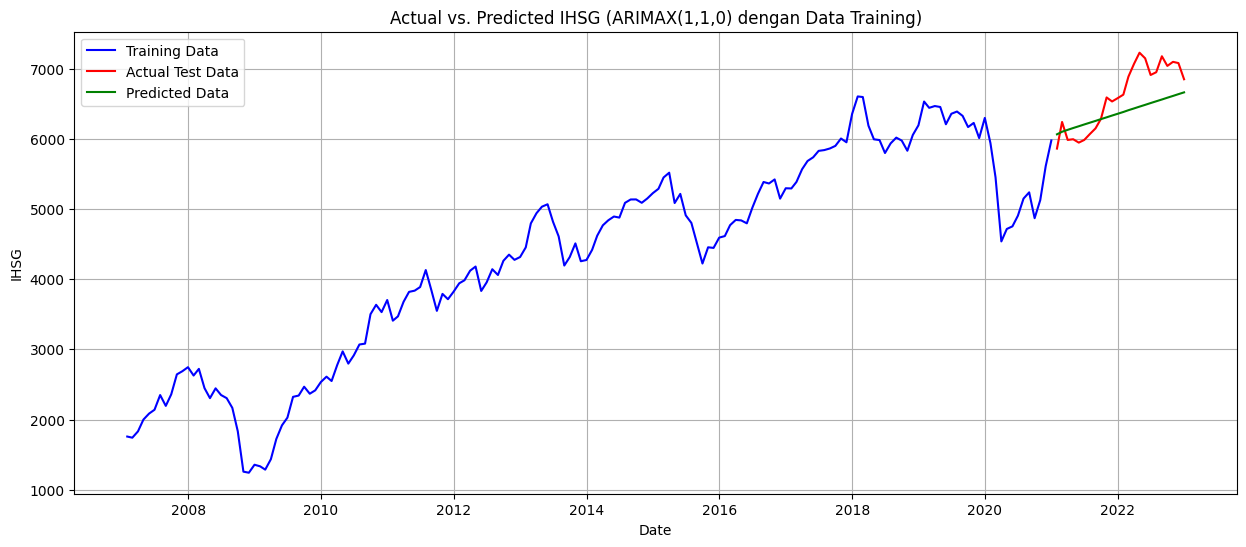

In [49]:
# === Plot data aktual vs. prediksi ===
plt.figure(figsize=(15, 6))

# Plot data training
plt.plot(train.index, y_train, label='Training Data', color='blue')

# Plot data testing aktual
plt.plot(test.index, y_test, label='Actual Test Data', color='red')

# Plot hasil prediksi ARIMAX (sudah transformasi balik)
plt.plot(y_test.index, predicted, label='Predicted Data', color='green')

plt.xlabel('Date')
plt.ylabel('IHSG')
plt.title('Actual vs. Predicted IHSG (ARIMAX(1,1,0) dengan Data Training)')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# === Evaluasi Model ===
# Invers transformasi (Jika perlu) atau gunakan nilai asli prediksi
mape_test = mean_absolute_percentage_error(y_test, predicted)
mae_test = mean_absolute_error(y_test, predicted)
rmse_test = np.sqrt(mean_squared_error(y_test, predicted))

print("=== Evaluasi Model ARIMAX(1,1,0) pada Data Testing ===")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")


=== Evaluasi Model ARIMAX(1,1,0) pada Data Testing ===
MAPE: 0.0483
MAE : 328.1093
RMSE: 383.4325


Model ARIMA(1,1,0) menghasilkan prediksi nilai IHSG dengan nilai MAPE sebesar 4.83%. Nilai MAPE yang rendah menunjukkan bahwa model memiliki tingkat kesalahan relatif yang kecil dan cukup akurat dalam memproyeksikan pergerakan IHSG.

## FORECASTING DATA TESTING OPEN

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# === Forecasting Data Testing dengan ARIMAX(1,1,0) ===
forecast = model_ar1open.get_forecast(steps=len(y_test_open))
predicted_diff = forecast.predicted_mean

# Invers differencing: hasil = nilai terakhir training + kumulatif prediksi selisih
predicted = y_train_open.iloc[-1] + predicted_diff.cumsum()

# Buat DataFrame hasil prediksi
hasil_forecast = y_test_open.copy()
hasil_forecast = hasil_forecast.to_frame(name='Aktual')
hasil_forecast['Prediksi'] = predicted.values

# Tampilkan hasil prediksi
print("=== Hasil Prediksi ARIMA(1,1,0) OPEN pada Data Testing ===")
print(hasil_forecast)

=== Hasil Prediksi ARIMA(1,1,0) OPEN pada Data Testing ===
             Aktual     Prediksi
Date                            
2021-01-31  5997.83  5756.811796
2021-02-28  5856.78  5798.045826
2021-03-31  6281.86  5824.593004
2021-04-30  5988.02  5848.363637
2021-05-31  5999.66  5871.609363
2021-06-30  6002.48  5894.755857
2021-07-31  6001.12  5917.883591
2021-08-31  6098.01  5941.007778
2021-09-30  6157.82  5964.131295
2021-10-31  6269.24  5987.254685
2021-11-30  6618.12  6010.378051
2021-12-31  6544.52  6033.501412
2022-01-31  6586.26  6056.624773
2022-02-28  6657.79  6079.748133
2022-03-31  6964.70  6102.871493
2022-04-30  7093.70  6125.994854
2022-05-31  7154.92  6149.118214
2022-06-30  7130.60  6172.241574
2022-07-31  6911.58  6195.364935
2022-08-31  6951.12  6218.488295
2022-09-30  7178.59  6241.611655
2022-10-31  7040.80  6264.735016
2022-11-30  7098.93  6287.858376
2022-12-31  7081.19  6310.981737


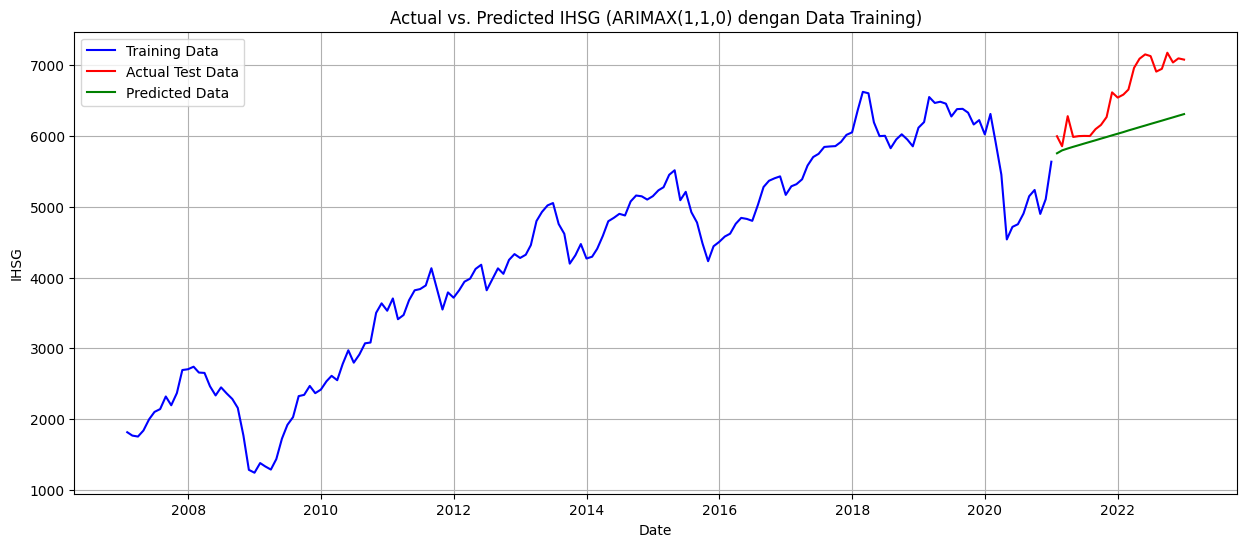

In [52]:
# === Plot data aktual vs. prediksi ===
plt.figure(figsize=(15, 6))

# Plot data training
plt.plot(train.index, y_train_open, label='Training Data', color='blue')

# Plot data testing aktual
plt.plot(test.index, y_test_open, label='Actual Test Data', color='red')

# Plot hasil prediksi ARIMAX (sudah transformasi balik)
plt.plot(y_test_open.index, predicted, label='Predicted Data', color='green')

plt.xlabel('Date')
plt.ylabel('IHSG')
plt.title('Actual vs. Predicted IHSG (ARIMAX(1,1,0) dengan Data Training)')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# === Evaluasi Model ===
# Invers transformasi (Jika perlu) atau gunakan nilai asli prediksi
mape_test = mean_absolute_percentage_error(y_test_open, predicted)
print("=== Evaluasi Model ARIMAX(0,1,1) pada Data Testing OPEN ===")
print(f"MAPE: {mape_test:.4f}")


=== Evaluasi Model ARIMAX(0,1,1) pada Data Testing OPEN ===
MAPE: 0.0769


# PERAMALAN 1 TAHUN KEDEPAN

## CLOSE

=== Hasil Peramalan IHSG 24 Bulan ke Depan (ARIMA(1,1,0)) ===
              Peramalan
2023-01-01  6065.735433
2023-02-01  6102.146672
2023-03-01  6129.537828
2023-04-01  6155.309976
2023-05-01  6180.791531
2023-06-01  6206.220927
2023-07-01  6231.640961
2023-08-01  6257.059315
2023-09-01  6282.477367
2023-10-01  6307.895365
2023-11-01  6333.313353
2023-12-01  6358.731340
2024-01-01  6384.149326
2024-02-01  6409.567312
2024-03-01  6434.985298
2024-04-01  6460.403284
2024-05-01  6485.821270
2024-06-01  6511.239256
2024-07-01  6536.657243
2024-08-01  6562.075229
2024-09-01  6587.493215
2024-10-01  6612.911201
2024-11-01  6638.329187
2024-12-01  6663.747173


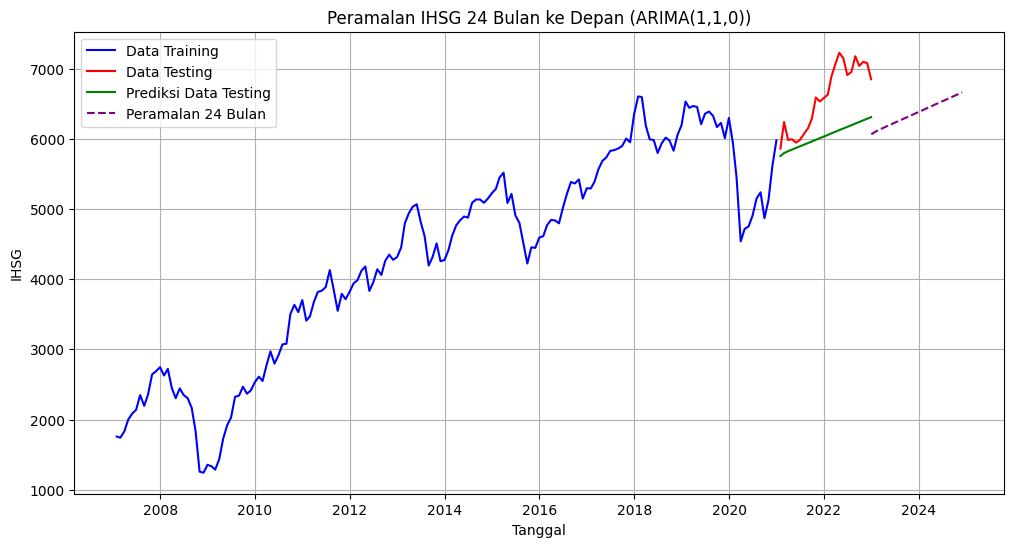

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Menentukan periode peramalan (24 bulan ke depan, mulai Januari 2025)
future_dates = pd.date_range(start='2023-01-01', periods=24, freq='MS')

# Melakukan peramalan menggunakan model ARIMA(1,1,0)
forecast = model_ar1.get_forecast(steps=24)
predicted_diff_future = forecast.predicted_mean

# Invers differencing untuk mendapatkan nilai IHSG
predicted_future = y_train.iloc[-1] + predicted_diff_future.cumsum()

# Membuat DataFrame hasil peramalan
hasil_peramalan = pd.DataFrame(index=future_dates, columns=['Peramalan'])
hasil_peramalan['Peramalan'] = predicted_future.values

# Menampilkan hasil peramalan
print("=== Hasil Peramalan IHSG 24 Bulan ke Depan (ARIMA(1,1,0)) ===")
print(hasil_peramalan)

# Plot data
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(y_train.index, y_train, label='Data Training', color='blue')

# Plot data testing aktual
plt.plot(y_test.index, y_test, label='Data Testing', color='red')

# Plot hasil prediksi ARIMA (sudah transformasi balik)
plt.plot(y_test.index, predicted, label='Prediksi Data Testing', color='green')

# Plot peramalan 24 bulan ke depan
plt.plot(hasil_peramalan.index, hasil_peramalan['Peramalan'], label='Peramalan 24 Bulan', color='purple', linestyle='--')

# Menambahkan label dan judul
plt.xlabel('Tanggal')
plt.ylabel('IHSG')
plt.title('Peramalan IHSG 24 Bulan ke Depan (ARIMA(1,1,0))')
plt.legend()
plt.grid(True)

# Menampilkan plot
plt.show()

##OPEN

=== Hasil Peramalan IHSG Open 24 Bulan ke Depan (AR(1)) ===
              Peramalan
2023-01-01  5756.811796
2023-02-01  5798.045826
2023-03-01  5824.593004
2023-04-01  5848.363637
2023-05-01  5871.609363
2023-06-01  5894.755857
2023-07-01  5917.883591
2023-08-01  5941.007778
2023-09-01  5964.131295
2023-10-01  5987.254685
2023-11-01  6010.378051
2023-12-01  6033.501412
2024-01-01  6056.624773
2024-02-01  6079.748133
2024-03-01  6102.871493
2024-04-01  6125.994854
2024-05-01  6149.118214
2024-06-01  6172.241574
2024-07-01  6195.364935
2024-08-01  6218.488295
2024-09-01  6241.611655
2024-10-01  6264.735016
2024-11-01  6287.858376
2024-12-01  6310.981737


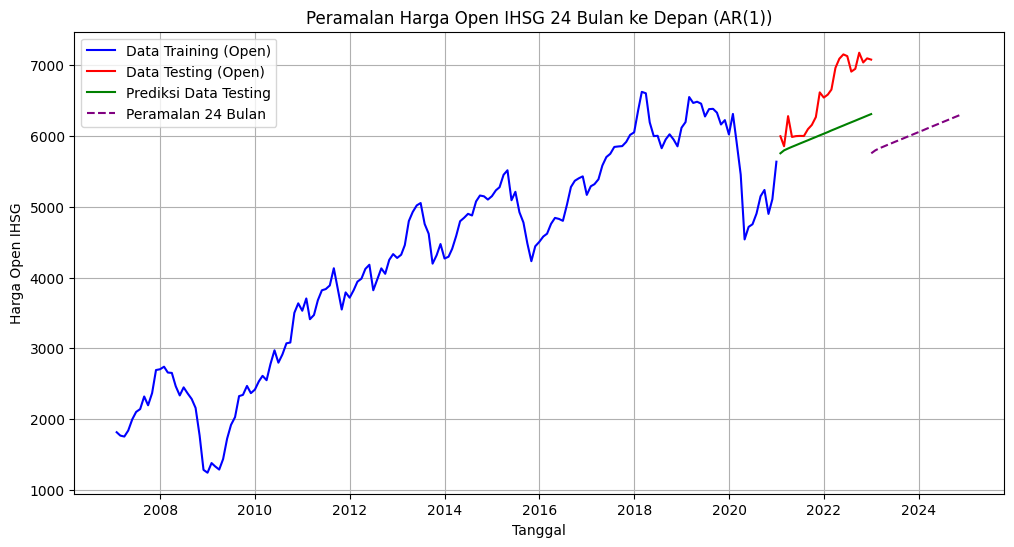

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Menentukan periode peramalan (24 bulan ke depan, mulai Januari 2025)
future_dates = pd.date_range(start='2023-01-01', periods=24, freq='MS')

# Melakukan peramalan menggunakan model AR(1) untuk data Open
forecast = model_ar1open.get_forecast(steps=24)
predicted_diff_future = forecast.predicted_mean

# Invers differencing untuk mendapatkan nilai prediksi aktual
predicted_future = y_train_open.iloc[-1] + predicted_diff_future.cumsum()

# Membuat DataFrame hasil peramalan
hasil_peramalan = pd.DataFrame(index=future_dates, columns=['Peramalan'])
hasil_peramalan['Peramalan'] = predicted_future.values

# Menampilkan hasil peramalan
print("=== Hasil Peramalan IHSG Open 24 Bulan ke Depan (AR(1)) ===")
print(hasil_peramalan)

# Plot data
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(y_train_open.index, y_train_open, label='Data Training (Open)', color='blue')

# Plot data testing aktual
plt.plot(y_test_open.index, y_test_open, label='Data Testing (Open)', color='red')

# Plot hasil prediksi (menggunakan nama 'predicted' seperti sebelumnya)
plt.plot(y_test_open.index, predicted, label='Prediksi Data Testing', color='green')

# Plot peramalan 24 bulan ke depan
plt.plot(hasil_peramalan.index, hasil_peramalan['Peramalan'], label='Peramalan 24 Bulan', color='purple', linestyle='--')

# Tambahkan label dan judul
plt.xlabel('Tanggal')
plt.ylabel('Harga Open IHSG')
plt.title('Peramalan Harga Open IHSG 24 Bulan ke Depan (AR(1))')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()